<a href="https://colab.research.google.com/github/dgsob/Deep-Learning-RSS/blob/main/coding%20exercises/exercise2/cifar10_jax_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
!pip install equinox

In [2]:
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org

In [3]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [4]:
import matplotlib.pyplot as plt

## Hyperparameters

In [5]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
STEPS = 8000
PRINT_EVERY = 500
SEED = 77

key = jax.random.PRNGKey(SEED)

## Download and prepare the CIFAR10 dataset

In [6]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),  # automatically normalizes pixel values to be between 0 and 1
    ]
)
train_dataset = torchvision.datasets.CIFAR10(
    "CIFAR10",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.CIFAR10(
    "CIFAR10",
    train=False,
    download=True,
    transform=normalise_data,
)

In [7]:
key, subkey = jax.random.split(key, 2)
generator = torch.Generator().manual_seed(int(subkey[0]))

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator
)
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator
)

## Verify the data

In [8]:
dummy_x, dummy_y = next(iter(train_dataset_loader)) # take a batch of data for inspection
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(f"Features shape: {dummy_x.shape}")
print(f"Targets shape: {dummy_y.shape}")
print(f"Maximum pixel value in features: {dummy_x.max()}")
print(f"Target values: {dummy_y}")

Features shape: (32, 3, 32, 32)
Targets shape: (32,)
Maximum pixel value in features: 1.0
Target values: [1 9 0 6 4 8 9 6 2 2 8 1 8 0 2 9 5 8 7 1 3 1 7 2 3 3 3 2 0 5 1 1]


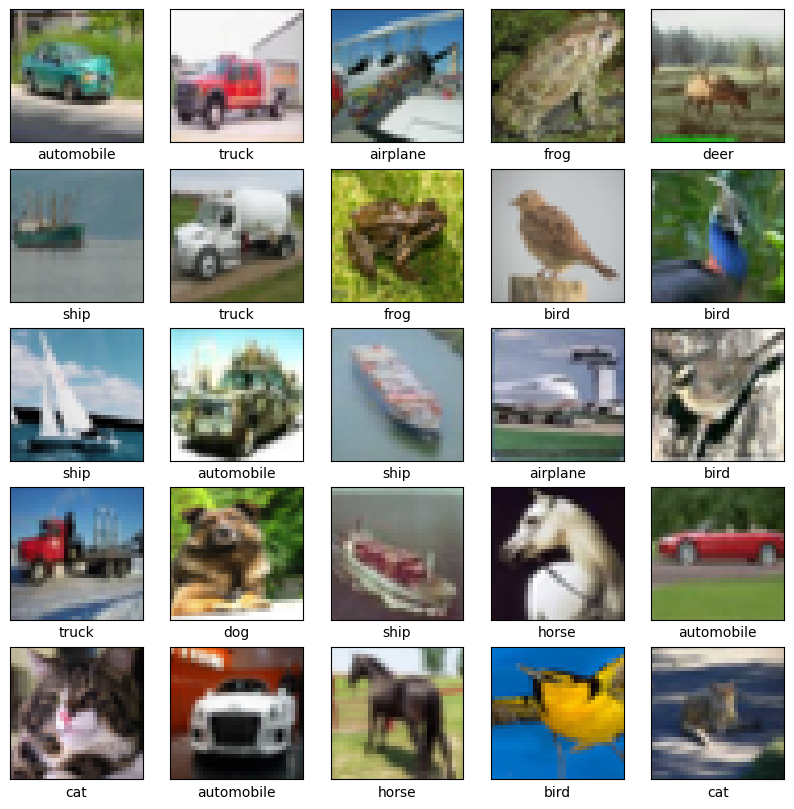

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

images = dummy_x[:25].transpose(0, 2, 3, 1)
labels = dummy_y[:25]
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(class_names[labels[i]])
plt.show()

## Define the Model

In [10]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        # Conv2d layers expect (H, W, C) input
        self.layers = [
            eqx.nn.Conv2d(3, 32, kernel_size=3, key=key1), # (32, 32, 3) -> (30, 30, 32)
            eqx.nn.MaxPool2d(kernel_size=2, stride=2),  # (30, 30, 32) -> (15, 15, 32)
            jax.nn.relu,

            eqx.nn.Conv2d(32, 64, kernel_size=3, key=key2), # (15, 15, 32) -> (13, 13, 64)
            eqx.nn.MaxPool2d(kernel_size=2, stride=2),  # (13, 13, 64) -> (6, 6, 64)
            jax.nn.relu,

            eqx.nn.Conv2d(64, 64, kernel_size=3, key=key3), # (6, 6, 64) -> (4, 4, 64)
            jax.nn.relu,

            lambda x: jnp.ravel(x),  # (4, 4, 64) -> (, 1024)

            eqx.nn.Linear(1024, 64, key=key4),  # (, 1024) -> (, 64)

            eqx.nn.Linear(64, 10, key=key5)  # (, 64) -> (, 10)
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [11]:
key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

In [12]:
print(model)

CNN(
  layers=[
    Conv2d(
      num_spatial_dims=2,
      weight=f32[32,3,3,3],
      bias=f32[32,1,1],
      in_channels=3,
      out_channels=32,
      kernel_size=(3, 3),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(2, 2),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    <PjitFunction of <function relu at 0x788a7ff4aa20>>,
    Conv2d(
      num_spatial_dims=2,
      weight=f32[64,32,3,3],
      bias=f32[64,1,1],
      in_channels=32,
      out_channels=64,
      kernel_size=(3, 3),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2)

## Loss and Optimiser

In [13]:
@eqx.filter_jit
def loss(
    model: CNN,
    x: Float[Array, "batch height width channels"],
    y: Int[Array, "batch"]
) -> Float[Array, ""]:
    y_pred = jax.vmap(model)(x)
    return optax.softmax_cross_entropy_with_integer_labels(y_pred, y).mean()

In [14]:
optim = optax.adam(LEARNING_RATE)

In [15]:
# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value)  # scalar loss

2.2975836


In [16]:
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions

(32, 10)


## Define Evaluation function

In [17]:
@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch height width channels"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

In [18]:
def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)

In [19]:
# evaluate(model, test_dataset_loader)

## Training

In [20]:
@eqx.filter_jit
def make_step(
    model: CNN,
    params: PyTree[Array],
    x: Float[Array, "batch height width channels"],
    y: Int[Array, "batch"]
):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, params = optim.update(grads, params, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)

    return model, params, loss_value

In [21]:
def infinite_trainloader():
        while True:
            yield from train_dataset_loader

In [22]:
print(f"Training for {STEPS / (len(train_dataset)/BATCH_SIZE)} epochs.")

Training for 5.12 epochs.


In [23]:
def training_loop(
    model: CNN,
    train_dataset_loader: torch.utils.data.DataLoader,
    test_dataset_loader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int
) -> CNN:

    params = optim.init(eqx.filter(model, eqx.is_array))

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        x = x.numpy()
        y = y.numpy()

        # Train the params and update the model's state
        model, params, train_loss = make_step(model, params, x, y)

        # Print some feadback
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, test_dataset_loader)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )

    return model

In [24]:
model = training_loop(model,
                      train_dataset_loader,
                      test_dataset_loader,
                      optim,
                      STEPS,
                      PRINT_EVERY)

step=0, train_loss=2.304900646209717, test_loss=2.301948308944702, test_accuracy=0.14167332649230957
step=500, train_loss=1.6416990756988525, test_loss=1.6038191318511963, test_accuracy=0.40515175461769104
step=1000, train_loss=1.3510017395019531, test_loss=1.40890634059906, test_accuracy=0.48412540555000305
step=1500, train_loss=1.1776539087295532, test_loss=1.365500807762146, test_accuracy=0.5134784579277039
step=2000, train_loss=1.3115477561950684, test_loss=1.2778246402740479, test_accuracy=0.5384384989738464
step=2500, train_loss=1.6702048778533936, test_loss=1.2724701166152954, test_accuracy=0.5487220287322998
step=3000, train_loss=1.073136329650879, test_loss=1.166011095046997, test_accuracy=0.581569492816925
step=3500, train_loss=1.1822960376739502, test_loss=1.1263781785964966, test_accuracy=0.5988418459892273
step=4000, train_loss=1.21405029296875, test_loss=1.099257469177246, test_accuracy=0.6132188439369202
step=4500, train_loss=1.3311357498168945, test_loss=1.0992163419723